In [ ]:
from imports import *
from utils import *

In [ ]:
#@title Preprocessing and EDA (Exploratory Data Analysis)

class preprocessing:

  # Function to read the .csv data set file and extract features and targets
  def __init__(self, path):
    self.df = pd.read_csv(path)
    self.columns = self.df.columns # column names
    self.targets = ['Biopsy', 'Hinselmann', 'Schiller', 'Citology'] # target
    #self.features = self.df.drop(['Biopsy', 'Hinselmann', 'Schiller', 'Citology'], axis=1)
    
  # Function to return the class count in each of the targets (y)
  def get_target_class_count(self, normalize=False):
    '''
    :param normalize (Boolean) : If set to false returns percentage of each class
    :return (pd dataframe) : class_count
    '''
    class_count = pd.DataFrame()
    for test in self.targets:
        class_count[test] = self.df[test].value_counts(normalize=normalize)
    return class_count

  # Function to set the missing data values
  def check_missing_data(self):
    self.df = self.df.replace('?', np.nan)
    columns_missing_count=self.check_columns()
    rows_missing_count=self.check_rows()
    return columns_missing_count,rows_missing_count

  # Function to deal with columns (features) with missing data
  def check_columns(self):
    columns_missing_count = self.df.isnull().sum(axis=0).to_frame().T
    N = len(self.df)
    delete = [columnName for (columnName, columnData) in columns_missing_count.iteritems() if (columnData.values[0] >= 0.80*N)]
    # print("Deleting columns with more sparsity",delete)
    self.df = self.df.drop(columns=delete) # delete columns with maximum missing values
    return columns_missing_count

  # Function to deal with rows (data point corresponding to each patient) with missing data
  def check_rows(self):
    missing_entries = self.df.isnull().sum(axis=1).tolist() # Count number of missing entries in each row
    null_mapping = dict((x, missing_entries.count(x)) for x in missing_entries) # Group rows with the same number of missing entries
    # print("Rows with null data", self.df.isnull().sum())
    self.df = self.df.dropna() # Remove all the rows with any null entries
    return null_mapping

  def set_dtype_as_float(self):
    '''
    Convert all categorical columns to float data
    '''
    cols = [col for col in self.df.columns if self.df[col].dtype == "object"]
    nunique = list(map(lambda col: self.df[col].nunique(), cols))
    unique_dict = dict(zip(cols, nunique))
    # print("\n No. of unique elements in each feature ",sorted(unique_dict.items(), key=lambda x: x[1]))
    self.df = self.df.astype({key: 'float64' for key in unique_dict})

  def correlation(self):
    corr_matrix = round(self.df.corr(), 2)
    top_corr_features = corr_matrix.index
    plt.figure(figsize=(20,20))
    g=sns.heatmap(self.df[top_corr_features].corr(),annot=True,fmt='.2f',cmap="YlGnBu")

  def box_plot(self):
    plt.figure(figsize=(16,4))
    self.df.iloc[:,:].boxplot()
    plt.title('(Raw) Distribution of Features', fontsize=17)
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.show()

  # Function to remove outliers determined by analyzing the box plot
  def remove_outliers(self):
    self.df.drop(self.df.index[self.df['Age'] > 52], inplace = True)
    self.df.drop(self.df.index[self.df['Number of sexual partners'] > 8], inplace = True)

  # Function to check the class imbalance for all target variables
  def target_variables(self):
    self.y1 = self.df.Hinselmann
    self.y2 = self.df.Schiller
    self.y3 = self.df.Citology
    self.y4 = self.df.Biopsy
    X = self.df.drop(['Hinselmann', 'Schiller', 'Citology', 'Biopsy'], axis=1)

    # Count number of class 1 and class 0 samples for each target
    print('_' * 30)
    print("Capturing Class Imbalance")
    print(self.y1.value_counts())
    print(self.y2.value_counts())
    print(self.y3.value_counts())
    print(self.y4.value_counts())

  # Function to convert 'Age' & 'First sexual intercourse' into age ranges
  def data_conversion(self):
    # Convert age to Age groups - Min age: 13, Max age: 52
    # 10 to 14 --> Group 1
    # 15 to 19 --> Group 2
    # ...
    # 50 to 54 --> Group 9
    age_bins = np.arange(9, 55 , 5)
    age_labels = np.arange(1, 10)
    self.df["age_group"] = pd.to_numeric(pd.cut(self.df.Age, bins = age_bins, labels = age_labels))
    print(self.df[['Age','age_group']].head(20))

    # Similarly convert first sexual intercourse age, Min age: 10, Max age: 32
    fsi_bins = np.arange(9, 35 , 5)
    fsi_labels = np.arange(1, 6)
    self.df['fsi_group'] = pd.to_numeric(pd.cut(self.df['First sexual intercourse'], bins = fsi_bins, labels = fsi_labels))
    print(self.df[['Age', 'First sexual intercourse', 'fsi_group']].head(20))
    self.df = self.df.drop(columns=['Age', 'First sexual intercourse'], axis=1) # Drop the columns of Age, First sexual intercourse,

  # Function to remove columns containing only a single unique value
  def unique_value(self):
    # Drop the columns of the 4 classes
    self.df = self.df.drop(['Biopsy', 'Hinselmann', 'Schiller', 'Citology'], axis=1)
    # Arrange the columns in ascending order of # unique values they contain
    print(self.df.nunique(axis=0).sort_values())
    # Remove the columns having only one unique value
    self.df = self.df.drop(['STDs:cervical condylomatosis', 'STDs:AIDS'], axis=1)
    print(self.df.columns)

    # Function for Regularization and Normalization of data
  def normalise_data(self, X):                  
    # First regularize data b/w 1 and 2
    scaler = MinMaxScaler(feature_range=(1, 2))
    pipeline = Pipeline(steps=[('s', scaler)])
    X = pipeline.fit_transform(X)
    X = pd.DataFrame(X)
    X.hist(figsize=(15,15))
    #display(X)
    return X

  def data_balancing(self):
    # Join the train data
    self.train1 = self.df.join(self.y1)
    self.train2 = self.df.join(self.y2)
    self.train3 = self.df.join(self.y3)
    self.train4 = self.df.join(self.y4)

    #print('Data (Hinselmann) shape before balancing:',len(train1))
    print('\nCounts of positive VS negative (Hinselmann) in original data:')
    print(self.train1.Hinselmann.value_counts())
    print('-'*40)

    #print('Data (Schiller) shape before balancing:',train2.shape)
    print('\nCounts of positive VS negative (Schiller) in original data:')
    print(self.train2.Schiller.value_counts())
    print('-'*40)

    #print('Data (Citology) shape before balancing:',train3.shape)
    print('\nCounts of positive VS negative (Citology) in original data:')
    print(self.train3.Citology.value_counts())
    print('-'*40)

    #print('Data (Biopsy) shape before balancing:',train4.shape)
    print('\nCounts of positive VS negative (Biopsy) in original data:')
    print(self.train4.Biopsy.value_counts())
    print('-'*40)

    # Oversample positives. Imblearn's ADASYN was built for class-imbalanced datasets
    X1_bal, y1_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(self.df,self.y1)

    # Oversample positives. Imblearn's ADASYN was built for class-imbalanced datasets
    X2_bal, y2_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(self.df,self.y2)

    # Oversample positives. Imblearn's ADASYN was built for class-imbalanced datasets
    X3_bal, y3_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(self.df,self.y3)

    # Oversample positives. Imblearn's ADASYN was built for class-imbalanced datasets
    X4_bal, y4_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(self.df,self.y4)

    # Join X and y
    X1_bal = pd.DataFrame(X1_bal,columns=self.df.columns)
    y1_bal = pd.DataFrame(y1_bal,columns=['Hinselmann'])
    balanced1 = X1_bal.join(y1_bal)

    # Join X and y
    X2_bal = pd.DataFrame(X2_bal,columns=self.df.columns)
    y2_bal = pd.DataFrame(y2_bal,columns=['Schiller'])
    balanced2 = X2_bal.join(y2_bal)

    # Join X and y
    X3_bal = pd.DataFrame(X3_bal,columns=self.df.columns)
    y3_bal = pd.DataFrame(y3_bal,columns=['Citology'])
    balanced3 = X3_bal.join(y3_bal)

    # Join X and y
    X4_bal = pd.DataFrame(X4_bal,columns=self.df.columns)
    y4_bal = pd.DataFrame(y4_bal,columns=['Biopsy'])
    balanced4 = X4_bal.join(y4_bal)

    print('-'*40)
    print('Data (Hinselmann) shape after balancing:',balanced1.shape)
    print('\nCounts of positive VS negative in new data:')
    print(balanced1.Hinselmann.value_counts())

    print('-'*40)
    print('Data (Schiller) shape after balancing:',balanced2.shape)
    print('\nCounts of positive VS negative in new data:')
    print(balanced2.Schiller.value_counts())

    print('-'*40)
    print('Data (Citology) shape after balancing:',balanced3.shape)
    print('\nCounts of positive VS negative in new data:')
    print(balanced3.Citology.value_counts())

    print('-'*40)
    print('Data (Biopsy) shape after balancing:',balanced4.shape)
    print('\nCounts of positive VS negative in new data:')
    print(balanced4.Biopsy.value_counts())

    y1_bal.columns.name = 'Hinselmann'
    y2_bal.columns.name = 'Schiller'
    y3_bal.columns.name = 'Citology'
    y4_bal.columns.name = 'Biopsy'

    targets = [y1_bal.columns.name, y2_bal.columns.name, y3_bal.columns.name, y4_bal.columns.name]

    return balanced1, balanced2, balanced3, balanced4

In [ ]:
obj = preprocessing("./data/risk_factors_cervical_cancer.csv")
preprocessing_data = {}

In [ ]:
obj.df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [ ]:
# Counting the positives (1) and negatives (0) for all the 4 targets (tests for cervical cancer diagnosis)
obj.get_target_class_count()

,Biopsy,Hinselmann,Schiller,Citology
0,803,823,784,814
1,55,35,74,44


In [ ]:
# Computing the percentages of the positives (1) and negatives (0) for all the 4 targets (tests for cervical cancer diagnosis)
obj.get_target_class_count(normalize=True)

,Biopsy,Hinselmann,Schiller,Citology
0,0.935897,0.959207,0.913753,0.948718
1,0.064103,0.040793,0.086247,0.051282


In [ ]:
# Displaying all the 32 features and the 4 target classes
obj.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

In [ ]:
# Displaying the data types of all the features and target classes
obj.df.dtypes

Age                                    int64
Number of sexual partners             object
First sexual intercourse              object
Num of pregnancies                    object
Smokes                                object
Smokes (years)                        object
Smokes (packs/year)                   object
Hormonal Contraceptives               object
Hormonal Contraceptives (years)       object
IUD                                   object
IUD (years)                           object
STDs                                  object
STDs (number)                         object
STDs:condylomatosis                   object
STDs:cervical condylomatosis          object
STDs:vaginal condylomatosis           object
STDs:vulvo-perineal condylomatosis    object
STDs:syphilis                         object
STDs:pelvic inflammatory disease      object
STDs:genital herpes                   object
STDs:molluscum contagiosum            object
STDs:AIDS                             object
STDs:HIV  

#### Step 1: Preprocessing the data set for treating missing values in columns(features) and rows(individual patient records)

In [ ]:
columns_missing_count, rows_missing_count = obj.check_missing_data()
preprocessing_data["columns_missing_count"] = columns_missing_count
preprocessing_data["rows_missing_count"] = rows_missing_count

In [ ]:
# Computing the number of missing values in each column
preprocessing_data["columns_missing_count"]

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,0,26,7,56,13,13,13,108,108,117,...,787,787,0,0,0,0,0,0,0,0


In [ ]:
# Computing the number of missing values in each row
preprocessing_data["rows_missing_count"]

{0: 668,
 1: 55,
 3: 14,
 20: 2,
 18: 75,
 4: 9,
 21: 3,
 19: 15,
 16: 3,
 2: 5,
 14: 4,
 7: 1,
 5: 1,
 17: 3}

In [ ]:
obj.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

#### Step 2 : Set categorial datatype to float

In [ ]:
obj.set_dtype_as_float()

In [ ]:
obj.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 668 non-null    int64  
 1   Number of sexual partners           668 non-null    float64
 2   First sexual intercourse            668 non-null    float64
 3   Num of pregnancies                  668 non-null    float64
 4   Smokes                              668 non-null    float64
 5   Smokes (years)                      668 non-null    float64
 6   Smokes (packs/year)                 668 non-null    float64
 7   Hormonal Contraceptives             668 non-null    float64
 8   Hormonal Contraceptives (years)     668 non-null    float64
 9   IUD                                 668 non-null    float64
 10  IUD (years)                         668 non-null    float64
 11  STDs                                668 non-n

In [ ]:
obj.df.describe()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,...,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,27.264970,2.523952,17.142216,2.323353,0.143713,1.235524,0.458953,0.643713,2.290037,0.112275,...,0.002994,0.092814,0.025449,0.004491,0.023952,0.023952,0.044910,0.094311,0.058383,0.067365
std,8.727432,1.640299,2.852046,1.465319,0.351061,4.193611,2.336308,0.479260,3.724400,0.315942,...,0.054677,0.310355,0.157603,0.066915,0.153015,0.153015,0.207262,0.292480,0.234642,0.250841
min,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,2.000000,17.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.000000,3.000000,18.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,1.000000,37.000000,37.000000,1.000000,22.000000,1.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Step 3 :  Correlation between features

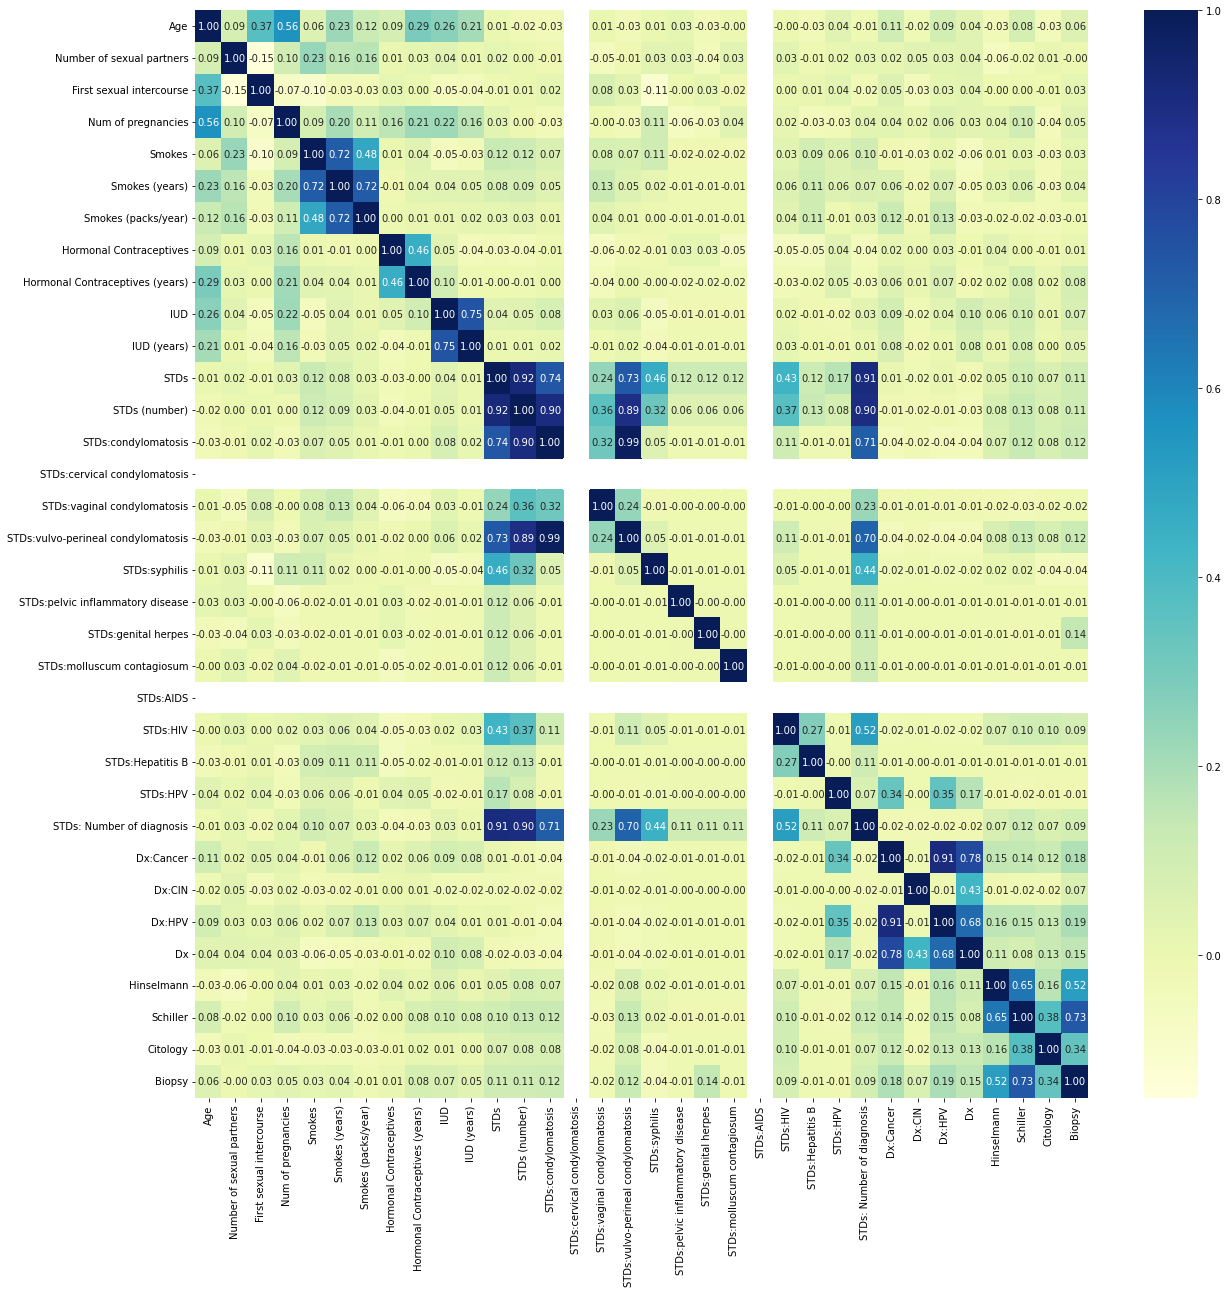

In [ ]:
obj.correlation()

#### Step 4 : Box Plot and Statistical Analysis

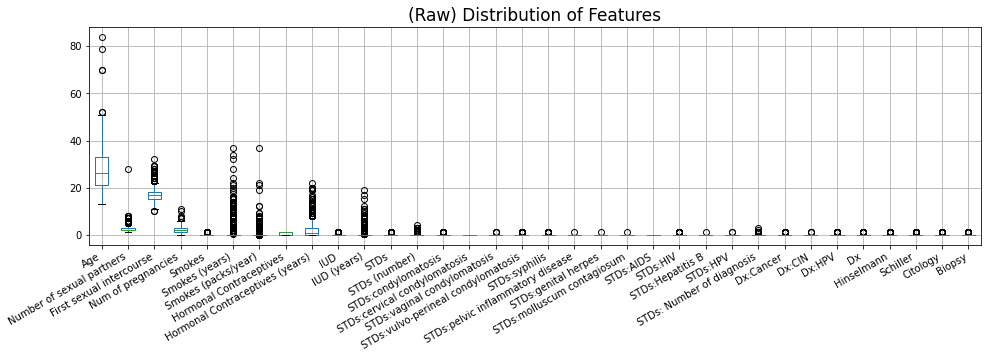

In [ ]:
obj.box_plot()

In [ ]:
obj.df.mode()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,23,2.0,15.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


In [ ]:
obj.df.median()

Age                                   26.0
Number of sexual partners              2.0
First sexual intercourse              17.0
Num of pregnancies                     2.0
Smokes                                 0.0
Smokes (years)                         0.0
Smokes (packs/year)                    0.0
Hormonal Contraceptives                1.0
Hormonal Contraceptives (years)        0.5
IUD                                    0.0
IUD (years)                            0.0
STDs                                   0.0
STDs (number)                          0.0
STDs:condylomatosis                    0.0
STDs:cervical condylomatosis           0.0
STDs:vaginal condylomatosis            0.0
STDs:vulvo-perineal condylomatosis     0.0
STDs:syphilis                          0.0
STDs:pelvic inflammatory disease       0.0
STDs:genital herpes                    0.0
STDs:molluscum contagiosum             0.0
STDs:AIDS                              0.0
STDs:HIV                               0.0
STDs:Hepati

#### Step 5: Outlier removal and computing class imbalance

In [ ]:
# Remove Outliers
obj.remove_outliers()

In [ ]:
# Computing Class Imbalance
obj.target_variables()

______________________________
Capturing Class Imbalance
0    633
1     30
Name: Hinselmann, dtype: int64
0    601
1     62
Name: Schiller, dtype: int64
0    624
1     39
Name: Citology, dtype: int64
0    618
1     45
Name: Biopsy, dtype: int64


#### Step 6: Data Conversion

In [ ]:
# Data Conversion
obj.data_conversion()

    Age  age_group
0    18          2
1    15          2
3    52          9
4    46          8
5    42          7
6    51          9
7    26          4
8    45          8
10   44          7
11   27          4
12   45          8
13   44          7
14   43          7
15   40          7
16   41          7
17   43          7
20   43          7
21   41          7
22   40          7
23   40          7
    Age  First sexual intercourse  fsi_group
0    18                      15.0          2
1    15                      14.0          1
3    52                      16.0          2
4    46                      21.0          3
5    42                      23.0          3
6    51                      17.0          2
7    26                      26.0          4
8    45                      20.0          3
10   44                      26.0          4
11   27                      17.0          2
12   45                      14.0          1
13   44                      25.0          4
14   43         

#### Step 7: Removing columns having a single unique value

In [ ]:
obj.unique_value()

STDs:cervical condylomatosis           1
STDs:AIDS                              1
STDs:vulvo-perineal condylomatosis     2
STDs:molluscum contagiosum             2
STDs:genital herpes                    2
STDs:pelvic inflammatory disease       2
STDs:syphilis                          2
STDs:Hepatitis B                       2
STDs:vaginal condylomatosis            2
STDs:condylomatosis                    2
STDs:HPV                               2
IUD                                    2
Dx:Cancer                              2
Hormonal Contraceptives                2
Dx:CIN                                 2
Dx:HPV                                 2
Smokes                                 2
Dx                                     2
STDs                                   2
STDs:HIV                               2
STDs: Number of diagnosis              4
fsi_group                              5
STDs (number)                          5
Number of sexual partners              8
Num of pregnanci

#### Step 8: Data Balancing

In [ ]:
balanced1, balanced2, balanced3, balanced4 = obj.data_balancing()


Counts of positive VS negative (Hinselmann) in original data:
0    633
1     30
Name: Hinselmann, dtype: int64
----------------------------------------

Counts of positive VS negative (Schiller) in original data:
0    601
1     62
Name: Schiller, dtype: int64
----------------------------------------

Counts of positive VS negative (Citology) in original data:
0    624
1     39
Name: Citology, dtype: int64
----------------------------------------

Counts of positive VS negative (Biopsy) in original data:
0    618
1     45
Name: Biopsy, dtype: int64
----------------------------------------
----------------------------------------
Data (Hinselmann) shape after balancing: (1269, 29)

Counts of positive VS negative in new data:
1    636
0    633
Name: Hinselmann, dtype: int64
----------------------------------------
Data (Schiller) shape after balancing: (1197, 29)

Counts of positive VS negative in new data:
0    601
1    596
Name: Schiller, dtype: int64
----------------------------------

In [ ]:
#@title Step 9.1: Storing the preprocessed data in 4 separate .csv files for each of the 4 classes
data_to_csv(balanced1, balanced2, balanced3, balanced4)

In [ ]:
#@title Step 9.2:  Converting the 4 .csv files to dataframes
df1, df2, df3, df4 = get_dataframe()

In [ ]:
#@title Step 10:  Extracting the feature vectors X and targets y as tuples for each of the 4 classes
data_tuple, targets, X1, y1, X2, y2, X3, y3, X4, y4 = get_X_and_y(df1, df2, df3, df4)

In [ ]:
#@title Step 11:  Splitting X and y into train and test data for each of the 4 classes
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state=42, stratify = y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=42, stratify = y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state=42, stratify = y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state=42, stratify = y4)

In [ ]:
# Creating a single data tuple of train data X_train and target labels y for each of the 4 classes
train_data = [(X1_train, y1_train), (X2_train, y2_train), (X3_train, y3_train), (X4_train, y4_train)]
test_data = [(X1_test, y1_test), (X2_test, y2_test), (X3_test, y3_test), (X4_test, y4_test)]

test1 = X1_test.join(y1_test)
test2 = X2_test.join(y2_test)
test3 = X3_test.join(y3_test)
test4 = X4_test.join(y4_test)

test_data_to_csv(test1, test2, test3, test4)


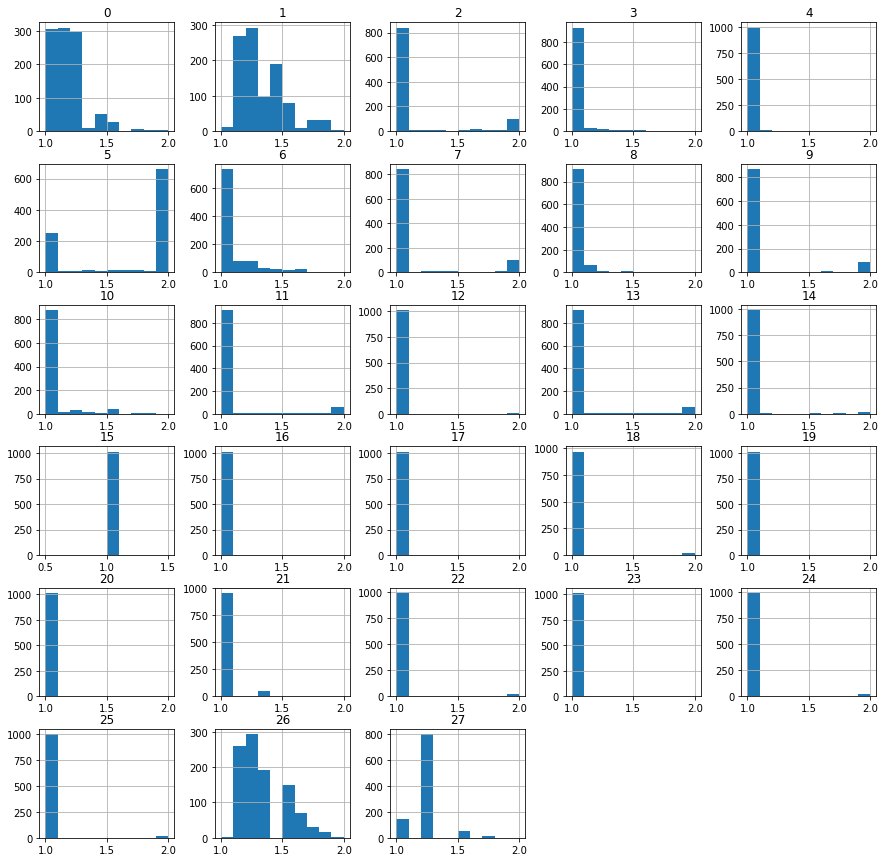

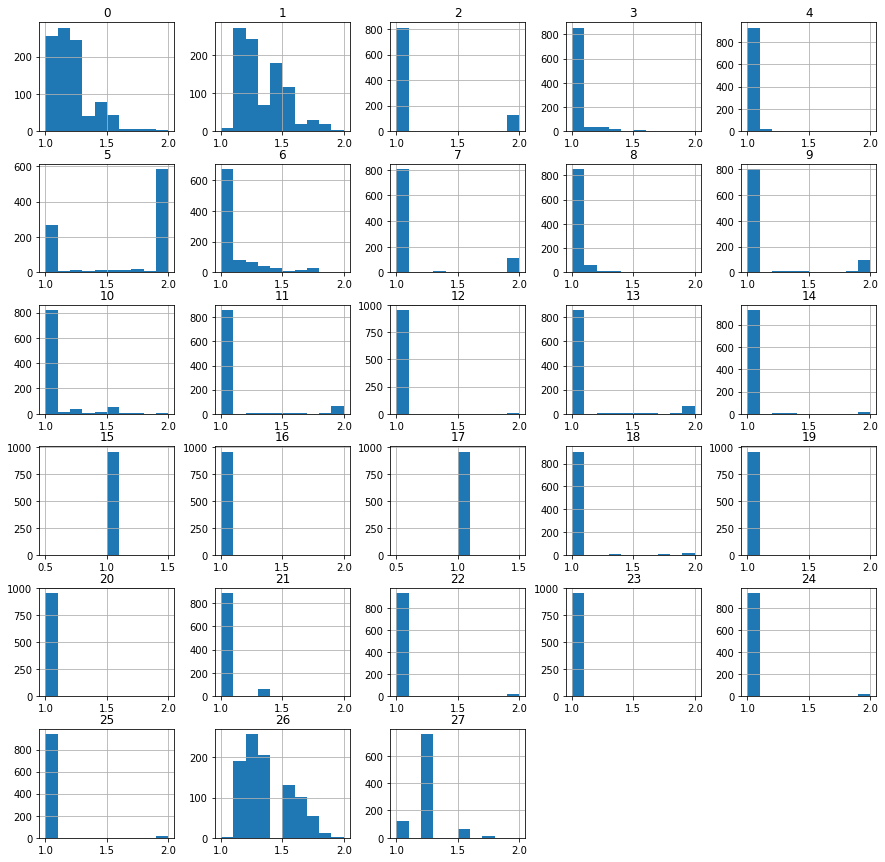

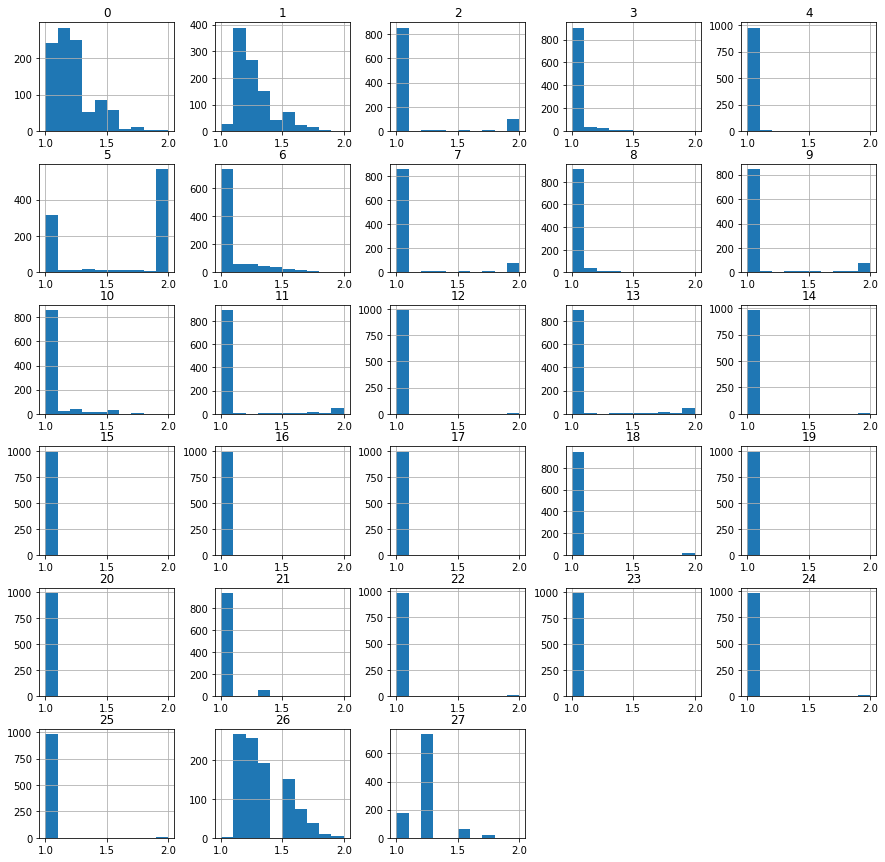

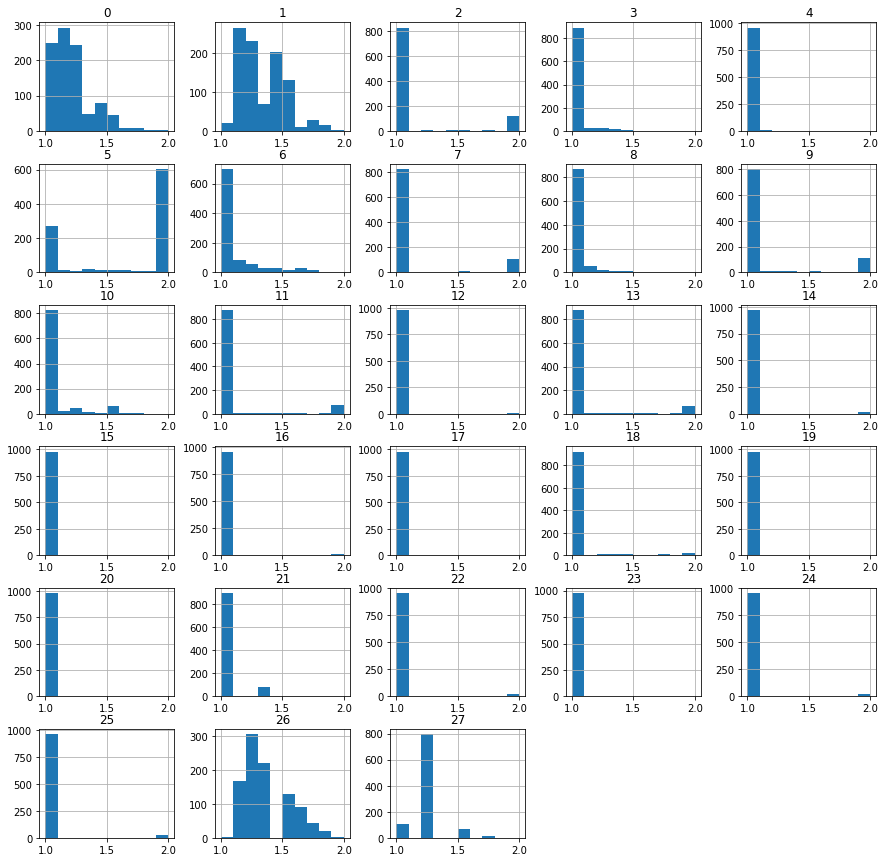

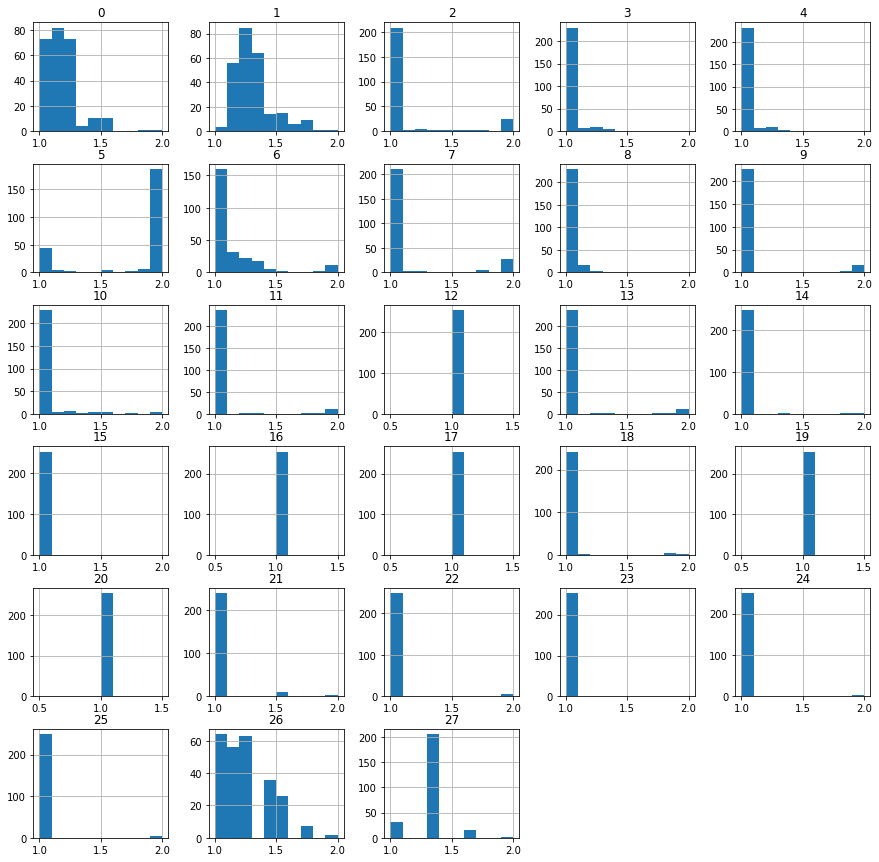

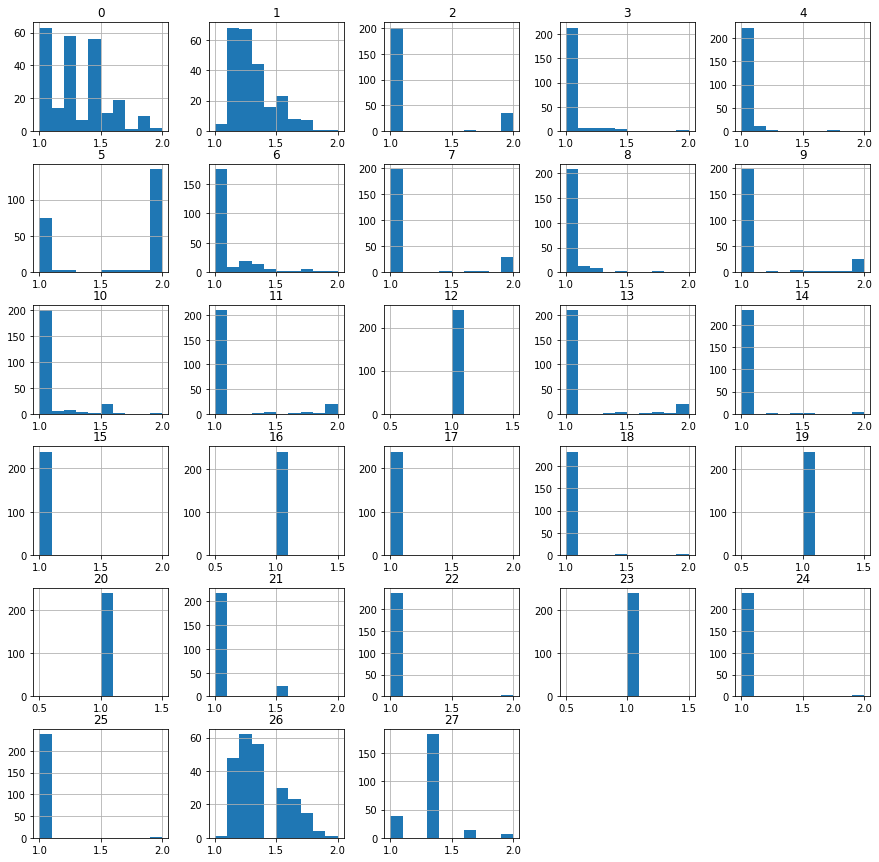

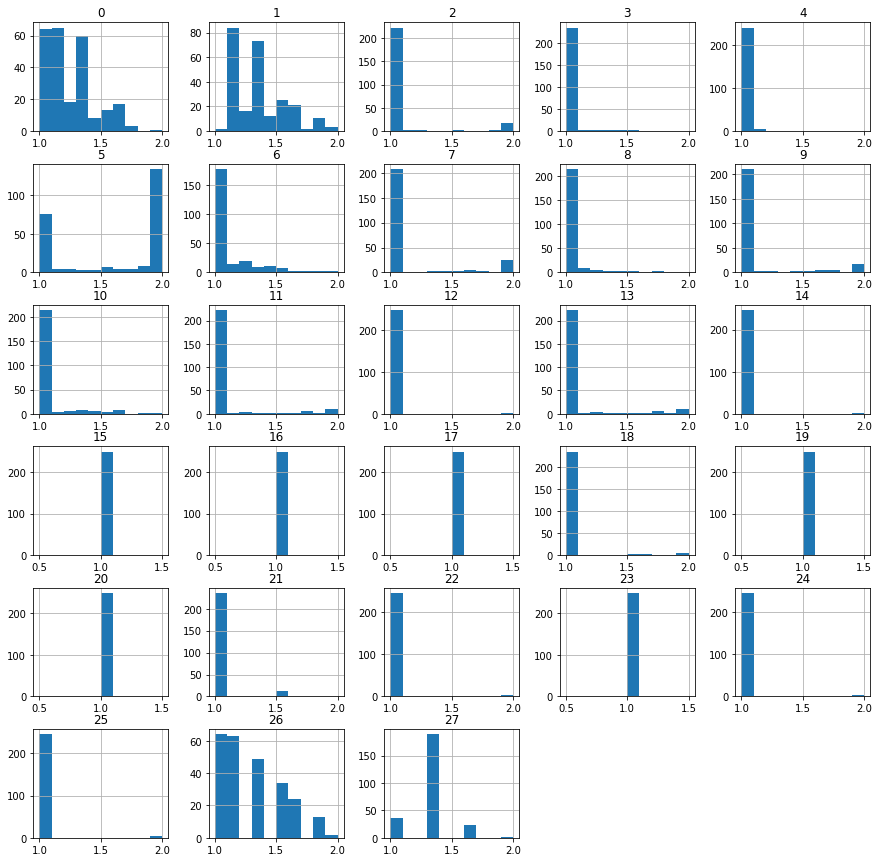

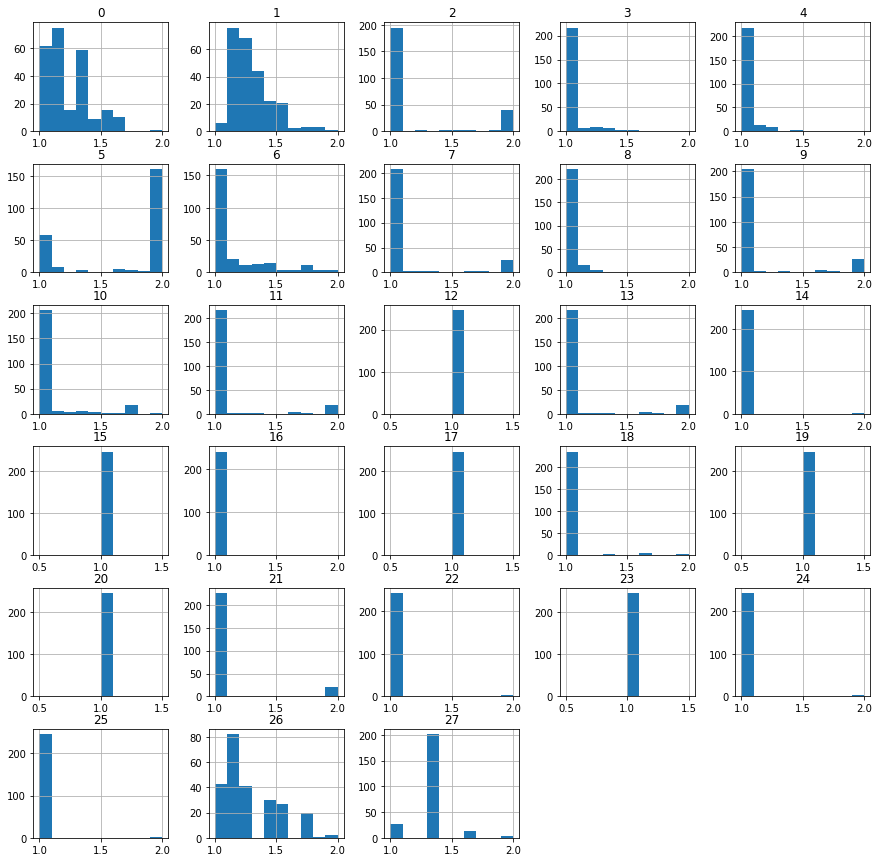

In [ ]:
#@title Step 12: Normalize Train Data
train_data_normalized = []
for i,value in enumerate(train_data):
    X,y = value
    Xnorm = obj.normalise_data(X)
    Xnorm.columns = X.columns
    train_data_normalized.append((Xnorm,y))
train_data = train_data_normalized

test_data_normalized = []
for i,value in enumerate(test_data):
    X,y = value
    Xnorm = obj.normalise_data(X)
    Xnorm.columns = X.columns
    test_data_normalized.append((Xnorm,y))
test_data = test_data_normalized

##Baseline Classifiers

In [ ]:
#@title Non-Trivial System: KNN
def baseline_knn(X_train, y_train, X_test, y_test):
  neighbors = np.arange(1, 9)
  train_accuracy = np.empty(len(neighbors))
  test_accuracy = np.empty(len(neighbors))

  # Looping over K values
  for i, k in enumerate(neighbors):

      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(X_train, y_train)
        
      # Computing training and test data accuracy
      train_accuracy[i] = knn.score(X_train, y_train)
      test_accuracy[i] = knn.score(X_test, y_test)

      # Displaying training and test accuracy for each value of n_neighbors = k
      print("# Neighbors = ", k)
      print("Train Accuracy: " + str(round(train_accuracy[i], 2) * 100) + " %")
      print("Test Accuracy: " + str(round(test_accuracy[i], 2) * 100) + " %")
      print("--------------------------------------------------------")
      if(k == 8):
        print("--------------------------------------------------------")

  # Computing the K value corresponding to the maximum train and test accuracy
  max_train_accuracy_K = train_accuracy.argmax() + 1
  max_test_accuracy_K = test_accuracy.argmax() + 1
  print("The Train Accuracy is maximum for K = ", max_train_accuracy_K)
  print("The Test Accuracy is maximum for K = ", max_test_accuracy_K)
  print("--------------------------------------------------------")
  print("--------------------------------------------------------")

  # Generating the plot of Accuracy vs # Neighbors comparing train/test accuracy
  plt.figure(1)
  plt.plot(neighbors, test_accuracy, label = 'Testing Dataset Accuracy')
  plt.plot(neighbors, train_accuracy, label = 'Training Dataset Accuracy') 
  plt.legend()
  plt.grid()
  plt.xlabel('Number of Neighbors')
  plt.ylabel('Accuracy')
  plt.show()
  print("--------------------------------------------------------")
  print("--------------------------------------------------------")

  # Predicting for the K value corresponding to the maximum test accuracy
  knn = KNeighborsClassifier(n_neighbors = max_test_accuracy_K)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_pred)
  print("The maximum Test Accuracy is: " + str(round((test_accuracy * 100), 2)) + " %.")
  print("--------------------------------------------------------")
  print("--------------------------------------------------------")
  print("Classification Report for K corresponding to the maximum Test Accuracy")
  print(classification_report(y_test, y_pred))
  print("--------------------------------------------------------")
  print("--------------------------------------------------------")
  print("Confusion Matrix for K corresponding to the maximum Test Accuracy")
  cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
  plt.figure(2)
  disp_cm = ConfusionMatrixDisplay(cm, display_labels=knn.classes_)
  disp_cm.plot()
  plt.show()

In [ ]:
#@title Trivial System: Probability-based
class TrivialSystem():
  def __init__(self, X, y, random_state=42):
    np.random.seed(random_state)
    self.random_state = random_state
    self.prob_cancer = np.mean(y)
  
  def fit(self, X, y, random_state=42):
    self.random_state = random_state
    self.y = y
    self.prob_cancer = np.mean(y)
    print(f"mean is {self.prob_cancer}")    
  
  def predict(self, data):
    print(data.shape)
    pred = [1 if np.random.rand() <= self.prob_cancer else 0 for _ in range(len(data))]
    return pred
  
  def score(self, ypred, yact):
    correct = np.sum(ypred==yact)
    return correct / len(yact)

In [ ]:
clfs, model_log = get_classifiers()
parameters_list = get_hyper_parameters()

In [ ]:
#@title Step 13: Convert SL to SSL dataset
train_data_20 = convert_for_all_tests(train_data,0.20)
train_data_60 = convert_for_all_tests(train_data,0.60)

train_data_labelled_20 = get_labelled_data(train_data_20)
train_data_labelled_60 = get_labelled_data(train_data_60)

# Baseline System Results

Baseline System Results for 20% unlabeled data

In [ ]:
for i in range(4):
  X_train,y_train = train_data_labelled_20[i][0], train_data_labelled_20[i][1]
  X_test,y_test = test_data[i][0], test_data[i][1]
  baseline_knn(X_train, y_train, X_test, y_test)
  # Trivial System 
  trv = TrivialSystem(X_train.to_numpy(), y_train.to_numpy())
  ypred = trv.predict(X_test.to_numpy())
  
  cm = confusion_matrix(y_test, ypred)
  cm_display = ConfusionMatrixDisplay(cm).plot()
  plt.show()
  
  print("Trivial Accuracy: ")#, trv.score(ypred, y_test.to_numpy()))
  print(classification_report(y_test.to_numpy(), ypred))

Baseline System Results for 60% unlabeled data

In [ ]:
for i in range(4):
  X_train,y_train = train_data_labelled_60[i][0], train_data_labelled_60[i][1]
  X_test,y_test = test_data[i][0], test_data[i][1]
  baseline_knn(X_train, y_train, X_test, y_test)
  # Trivial System 
  trv = TrivialSystem(X_train.to_numpy(), y_train.to_numpy())
  ypred = trv.predict(X_test.to_numpy())
  print("Accuracy: ", trv.score(ypred, y_test.to_numpy()))
  cm = confusion_matrix(y_test, ypred)
  cm_display = ConfusionMatrixDisplay(cm).plot()
  plt.show()
  print(classification_report(y_test, ypred))

In [ ]:
for i in range(4):
  X_train,y_train = train_data_labelled_20[i][0], train_data_labelled_20[i][1]
  X_test,y_test = test_data[i][0], test_data[i][1]
  baseline_knn(X_train, y_train, X_test, y_test)


In [ ]:
#@title Decision Boundary
from sklearn.feature_selection import SelectKBest, chi2
def get_decision_boundary(X,target,clfs,model_log,parameters_list):
  c = target.columns
  y = np.array(target[c].values.tolist()).T[0]
  X =  SelectKBest(chi2, k=2).fit_transform(X, y) #data.iloc[:, :2]
  # X = round(X,2)
  # step size in the mesh
  h = 0.02
  classifiers = []
  for i,clf in enumerate(clfs):
    cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    Grid=GridSearchCV(estimator=clf, param_grid=parameters_list[i],n_jobs=-1, cv=cv, verbose=3).fit(X, y)
    classifiers.append((Grid, y , model_log[i]))
    

  # create a mesh to plot in
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  color_map = {-1: (1, 1, 1), 0: (0, 0, 0.9), 1: (1, 0, 0), 2: (0.8, 0.6, 0)}

  # classifiers = (ls30, st30, ls50, st50, ls100, rbf_svc)
  plt.figure(figsize=(12,8))
  for i, (clf, target, title) in enumerate(classifiers):
      
      # Plot the decision boundary. For that, we will assign a color to each
      # point in the mesh [x_min, x_max]x[y_min, y_max].
      plt.subplot(3, 2, i + 1)
      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

      # Put the result into a color plot
      Z = Z.reshape(xx.shape)
      plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
      plt.axis("off")

      # Plot also the training points
      colors = [color_map[y] for y in target]
      plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors="black")

      plt.title(title)

  plt.suptitle("Unlabeled points are colored white", y=0.1)

SL Decision Boundary

In [ ]:
i =0
get_decision_boundary(train_data_labelled_20[i][0],train_data_labelled_20[i][1],clfs,model_log,parameters_list)


In [ ]:
i = 1
get_decision_boundary(train_data_labelled_20[i][0],train_data_labelled_20[i][1],clfs,model_log,parameters_list)

In [ ]:
i = 2
get_decision_boundary(train_data_labelled_20[i][0],train_data_labelled_20[i][1],clfs,model_log,parameters_list)

In [ ]:
i = 3
get_decision_boundary(train_data_labelled_20[i][0],train_data_labelled_20[i][1],clfs,model_log,parameters_list)

SSL Decision Boundary

In [ ]:
i =0
get_decision_boundary(train_data_20[i][0],train_data_20[i][1],clfs,model_log,parameters_list)

In [ ]:
i = 1
get_decision_boundary(train_data_20[i][0],train_data_20[i][1],clfs,model_log,parameters_list)

In [ ]:
i = 2
get_decision_boundary(train_data_20[i][0],train_data_20[i][1],clfs,model_log,parameters_list)

In [ ]:
i = 3
get_decision_boundary(train_data_20[i][0],train_data_20[i][1],clfs,model_log,parameters_list)

In [ ]:
# number of labelled unlabelled points in each tests for 20% unlabelled
print(train_data_20[0][1].value_counts(normalize=True))
print(train_data_20[1][1].value_counts(normalize=True))
print(train_data_20[2][1].value_counts(normalize=True))
print(train_data_20[3][1].value_counts(normalize=True))

In [ ]:
# number of labelled unlabelled points in each tests for 60% unlabelled
print(train_data_60[0][1].value_counts(normalize=True))
print(train_data_60[1][1].value_counts(normalize=True))
print(train_data_60[2][1].value_counts(normalize=True))
print(train_data_60[3][1].value_counts(normalize=True))

In [ ]:
#@title Step 14:  Hyperparameter Tuning 

# - 20% unlabelled
print("20% data")
best_params_20 = get_best_params(train_data_labelled_20,20,clfs,parameters_list,model_log)

print("60% data")
# - 60% unlabelled
best_params_60 = get_best_params(train_data_labelled_60,60,clfs,parameters_list,model_log)

In [ ]:
#@title Step 15: SL Model Training
def fit_SL(data,percentage,clfs,best_params):
  percentage_100 = percentage*100
  for i,value in enumerate(data):
    X,y = value
    best_param = best_params[i]
    for clf in clfs: # classifier 
      clf_name = clf.__class__.__name__
      ### best hyper-parameter set
      clf.set_params(**best_param[clf_name])

      ### fit
      clf.fit(X,y)

      ## save best model
      path = './SL_models/thresh_{}'.format(percentage_100)
      if not os.path.exists(path):
        os.mkdir(path)
      
      model_pkl = './SL_models/thresh_{}/SL_Test_{}_{}_model.pkl'.format(percentage_100,i,clf_name)
      if not os.path.exists(model_pkl):
        with open(model_pkl,'wb') as f:
          pickle.dump(clf,f)
        print("Saved ... {}".format(model_pkl))

In [ ]:
# SL for train_data_20
fit_SL(train_data_labelled_20,percentage=0.20,clfs=clfs,best_params=best_params_20)

In [ ]:
# SL for train_data_60
fit_SL(train_data_labelled_60,percentage=0.60,clfs=clfs,best_params=best_params_60)

In [ ]:
#@title Step 16: SSL Model Training
def fit_SSL(data,percentage,clf,best_params,thresh):
    percentage_100 = percentage*100
    for i,value in enumerate(data):
        ### get percentage amount of unalabelled labelled data  + labelled data
        # X_percentage, y_percentage = convert_sl_to_ssl_data(X,y,percentage)
        X_percentage, y_percentage = value
        best_param = best_params[i]
        for clf in clfs:
          clf_name = clf.__class__.__name__
        
          # best hyper-parameter set
          clf.set_params(**best_param[clf_name])

          ### fit SSL classifier
          ssl_clf = SelfTrainingClassifier(base_estimator=clf,threshold=thresh,verbose=True).fit(X_percentage, y_percentage)
          ssl_clf_pred = ssl_clf.predict(X_percentage)
          ssl_clf_acc = accuracy_score(y_percentage, ssl_clf_pred)
          print("percentage " ,str(percentage))
          print(" Test{}".format(i), " clf{}".format(clf_name))
          print(ssl_clf_acc)

          ### save best percentage_100
          path = './SSL_models/thresh_{}'.format(percentage_100)
          if not os.path.exists(path):
            os.mkdir(path)
          
          model_pkl = './SSL_models/thresh_{}/SSL_Test_{}_{}_model.pkl'.format(percentage_100,i,clf_name)
          if not os.path.exists(model_pkl):
            with open(model_pkl,'wb') as f:
              pickle.dump(ssl_clf,f)
            print("Saved ... {} {}".format(str(percentage),model_pkl))


In [ ]:
# SSL 0.20
fit_SSL(data=train_data_20,percentage=0.20,clf=clfs,best_params=best_params_20,thresh=0.7)

In [ ]:
# SSL 0.60
fit_SSL(data=train_data_20,percentage=0.60,clf=clfs,best_params=best_params_60,thresh=0.7)

References:

*   Kaggle
1.   https://www.kaggle.com/code/saqibsarwarkhan/cervical-cancer-risk-analysis
2.   https://www.kaggle.com/datasets/loveall/cervical-cancer-risk-classification


*   GitHub
1.   https://github.com/topics/cervical-cancer
2.   https://github.com/avivace/cervical-cancer/blob/master/report.pdf


*   Datahub.io: https://datahub.io/machine-learning/cervical-cancer




